## Installation of the required libraries

In [1]:
!pip install findspark
!pip install xlrd
!pip install scikit-learn
!pip install scikit-plot
!pip install kds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# needed in colab, remove this cell when executing on VMs
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=0bf06424ffd69c0d1abcd119547076a336649f5b38a52d1dec8177def89216ba
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


## Import of the libraries

In [3]:
import json

import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import kds
from sklearn.metrics import classification_report
%matplotlib inline

import findspark
#findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType,\
                              StructField,\
                              IntegerType,\
                              DoubleType,\
                              StringType
from pyspark.ml.feature import StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType

## Loading block
The following block is needed to load the dataset from the excel file,
create the current spark session, build the pyspark dataframe containing
the data and show its the schema.

In [4]:
credit = pd.read_excel('./default of credit card clients.xls', header=1)


spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

credit_schema = StructType([\
    StructField("ID", IntegerType(), False),
    StructField("LIMIT_BAL", IntegerType(), False),
    StructField("SEX", IntegerType(), False),
    StructField("EDUCATION", IntegerType(), False),
    StructField("MARRIAGE", IntegerType(), False),
    StructField("AGE", IntegerType(), False),
    StructField("PAY_0", IntegerType(), False),
    StructField("PAY_2", IntegerType(), False),
    StructField("PAY_3", IntegerType(), False),
    StructField("PAY_4", IntegerType(), False),
    StructField("PAY_5", IntegerType(), False),
    StructField("PAY_6", IntegerType(), False),
    StructField("BILL_AMT1", IntegerType(), False),
    StructField("BILL_AMT2", IntegerType(), False),
    StructField("BILL_AMT3", IntegerType(), False),
    StructField("BILL_AMT4", IntegerType(), False),
    StructField("BILL_AMT5", IntegerType(), False),
    StructField("BILL_AMT6", IntegerType(), False),
    StructField("PAY_AMT1", IntegerType(), False),
    StructField("PAY_AMT2", IntegerType(), False),
    StructField("PAY_AMT3", IntegerType(), False),
    StructField("PAY_AMT4", IntegerType(), False),
    StructField("PAY_AMT5", IntegerType(), False),
    StructField("PAY_AMT6", IntegerType(), False),
    StructField("default payment next month", IntegerType(), False)])

spark_credit= spark.createDataFrame(credit, schema = credit_schema)
spark_credit.printSchema()

root
 |-- ID: integer (nullable = false)
 |-- LIMIT_BAL: integer (nullable = false)
 |-- SEX: integer (nullable = false)
 |-- EDUCATION: integer (nullable = false)
 |-- MARRIAGE: integer (nullable = false)
 |-- AGE: integer (nullable = false)
 |-- PAY_0: integer (nullable = false)
 |-- PAY_2: integer (nullable = false)
 |-- PAY_3: integer (nullable = false)
 |-- PAY_4: integer (nullable = false)
 |-- PAY_5: integer (nullable = false)
 |-- PAY_6: integer (nullable = false)
 |-- BILL_AMT1: integer (nullable = false)
 |-- BILL_AMT2: integer (nullable = false)
 |-- BILL_AMT3: integer (nullable = false)
 |-- BILL_AMT4: integer (nullable = false)
 |-- BILL_AMT5: integer (nullable = false)
 |-- BILL_AMT6: integer (nullable = false)
 |-- PAY_AMT1: integer (nullable = false)
 |-- PAY_AMT2: integer (nullable = false)
 |-- PAY_AMT3: integer (nullable = false)
 |-- PAY_AMT4: integer (nullable = false)
 |-- PAY_AMT5: integer (nullable = false)
 |-- PAY_AMT6: integer (nullable = false)
 |-- default 

## Pre-processing
The following block is needed to drop the "ID" column, remove duplicate examples and outliers

In [5]:
spark_credit = spark_credit.drop('ID')
spark_credit = spark_credit.distinct()
spark_credit = spark_credit.where(col('LIMIT_BAL') <= 550000 ).where(col('PAY_AMT6') <= 50000)

## Splitting of the dataset

In [6]:
train_cred, test_cred = spark_credit.randomSplit([0.7, 0.3], seed = 1234)

## Standardization of the features
The following block is needed to assemble the previously created DataFrames and scale all the features by using the StandardScaler provided in spark.ml.feature.

In [7]:
col_list = [spark_credit.dtypes[i][0] for i in range(0, len(spark_credit.dtypes)-1)]
credit_vec_ass = VectorAssembler(inputCols = col_list, outputCol = "temp_features")

credit_assembled = credit_vec_ass.transform(spark_credit)
train_assembled = credit_vec_ass.transform(train_cred)
test_assembled = credit_vec_ass.transform(test_cred)

# in "Scaled" there will be values scaled with the corrected sample standard deviation,
# instead of the population-based standard deviation
spark_scaler = StandardScaler(withMean=True, withStd=True, inputCol="temp_features", outputCol="scaled")
fitted_scaler = spark_scaler.fit(dataset = credit_assembled)
scaled_data = fitted_scaler.transform(credit_assembled)
scaled_train = fitted_scaler.transform(train_assembled)
scaled_test = fitted_scaler.transform(test_assembled)

vectorized_scaled_data = scaled_data.select(["scaled", "default payment next month"])
vectorized_scaled_train = scaled_train.select(["scaled", "default payment next month"])
vectorized_scaled_test = scaled_test.select(["scaled", "default payment next month"])
print(vectorized_scaled_data.show())
print(vectorized_scaled_train.show())
print(vectorized_scaled_test.show())

+--------------------+--------------------------+
|              scaled|default payment next month|
+--------------------+--------------------------+
|[0.61459469682298...|                         0|
|[0.53457136090135...|                         0|
|[0.53457136090135...|                         0|
|[-0.9058486856880...|                         0|
|[0.45454802497971...|                         0|
|[-0.5857553420015...|                         0|
|[1.57487472788257...|                         0|
|[-0.5857553420015...|                         0|
|[-0.7458020138447...|                         0|
|[-0.1856386623933...|                         1|
|[-0.1056153264717...|                         1|
|[-0.1056153264717...|                         0|
|[1.09473471235277...|                         0|
|[-1.1459186934529...|                         0|
|[-0.9058486856880...|                         1|
|[0.85466470458788...|                         0|
|[0.05443134537155...|                         0|


## Construction and fitting of the Multilayer Perceptron classifier from spark.ml.classification
preliminarly to the construction of the classifier a further preprocessing step must be performed: the distribution of each feature must be in range \[0,1\]. <br>

In [8]:
min_max_scaler = MinMaxScaler(min=0.0, max=1.0, inputCol='scaled', outputCol="min_maxed_scaled")
fitted_min_max_scaler = min_max_scaler.fit(vectorized_scaled_data)
mm_scaled_train = fitted_min_max_scaler.transform(vectorized_scaled_train).select("min_maxed_scaled", "default payment next month")
mm_scaled_test = fitted_min_max_scaler.transform(vectorized_scaled_test).select("min_maxed_scaled", "default payment next month")

In [10]:
def serialize_df(df_to_ser, path_where_ser, df_name):
  """
  Function to serialize a pyspark dataframe to json while also saving its schema.

  Params:
    df_to_ser: dataframe to serialize
    path_where_ser: root directory where the files (one json file for the schema
                    and another one for data) will be saved
    df_name: the name of the dataset that must be serialized (it is a string
             that will be added to both json files)
  """
  schema_to_ser = df_to_ser.schema.json()  
  with open(path_where_ser + "%s_schema.json"%df_name, "w") as json_file:
    to_ser = json.dumps(schema_to_ser, indent = 4)
    json_file.write(to_ser)
  df_to_ser.write.json(path_where_ser + "/%s.json"%df_name, mode="overwrite")


def load_df(path_where_ser, df_name):
  """
  Function to load a pyspark dataframe known its schema.

  Params: 
    path_where_ser: root directory of the files of the 
                    serialized dataset and its schema
    df_name: actual name of the df (string that was used to give a name the
             json file)
  Returns:
    to_return: the loaded dataset with the loaded schema
  """
  with open(path_where_ser + "%s_schema.json"%df_name, "r") as json_file:
    json_obj = json.load(json_file)
    loaded_schema = StructType.fromJson(json.loads(json_obj))
  to_return = spark.read.format("json") \
                        .option("header", "true") \
                        .schema(loaded_schema) \
                        .load(path_where_ser + "/%s.json"%df_name)
  return to_return

serialize_df(mm_scaled_train, "/content/serialized/", "mm_scaled_train")
serialize_df(mm_scaled_test, "/content/serialized/", "mm_scaled_test")

In [11]:
mm_scaled_train = load_df("/content/serialized/", "mm_scaled_train")
mm_scaled_test = load_df("/content/serialized/", "mm_scaled_test")

In [16]:
mlpc=MultilayerPerceptronClassifier(featuresCol="min_maxed_scaled", 
                                    labelCol="default payment next month",
                                    layers = [23, 10, 5, 2],
                                    maxIter=100,
                                    blockSize=30,
                                    seed=10)

In [19]:
mlpc_fitted = mlpc.fit(mm_scaled_train)
print(mlpc.explainParams())
mlpc.write().overwrite().save("/content/serialized/mlpc-model")

blockSize: block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. (default: 128, current: 30)
featuresCol: features column name. (default: features, current: min_maxed_scaled)
initialWeights: The initial weights of the model. (undefined)
labelCol: label column name. (default: label, current: default payment next month)
layers: Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and output layer of 10 neurons. (current: [23, 10, 5, 2])
maxIter: max number of iterations (>= 0). (default: 100, current: 100)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. 

In [20]:
mlpc.load("/content/serialized/mlpc-model")

MultilayerPerceptronClassifier_bb723c4989b4

## Evaluation of the classifier
The cell below is needed to compute the performances of the classifier that has been fitted, in this case the "collect()" is a valid operation since it is performed on the test set only.

In [21]:
def plot_cumulative_gains_both_classes(y_true, y_probs):
  """
  Function to plot the cumulative gains chart.
  It plots the cumulative number of positive predictions made,
  as function of the total number of positive preditcions

  Params:
    y_true: an array of length num_examples containing the ground truth labels
    y_probs: the probabilities associated for each example
             to each label, it is an array of shape (num_examples, num_classes)  
  """
  skplt.metrics.plot_cumulative_gain(y_true, y_probs)
  plt.xlabel("Number of observations")
  plt.ylabel("Cumulative number of true positive predictions")
  plt.title("Cumulative Gains Chart")
  plt.show()

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6841
           1       0.67      0.34      0.45      1967

    accuracy                           0.82      8808
   macro avg       0.75      0.65      0.67      8808
weighted avg       0.80      0.82      0.79      8808



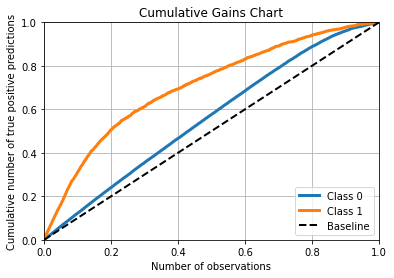

In [22]:
Y_true = mm_scaled_test.select("default payment next month").collect()
test_cred_no_def = mm_scaled_test.select("min_maxed_scaled")
Y_pred_df = mlpc_fitted.transform(test_cred_no_def)
Y_pred_probabilities = Y_pred_df.select("probability").collect()
Y_pred_predictions = Y_pred_df.select("prediction").collect()

Y_pred_probabilities_np = np.array(Y_pred_probabilities)
Y_pred_probabilities_np = np.reshape(Y_pred_probabilities_np, (Y_pred_probabilities_np.shape[0], 2))

data_y = np.array([elem[0] for elem in Y_true])

print(classification_report(Y_true, Y_pred_predictions))
plot_cumulative_gains_both_classes(data_y, Y_pred_probabilities_np)

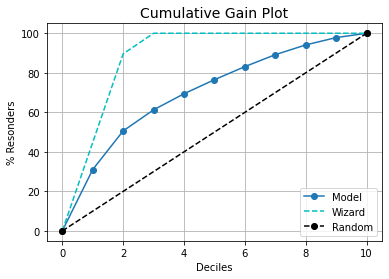

In [23]:
kds.metrics.plot_cumulative_gain(data_y, Y_pred_probabilities_np[:, 1])

In [ ]:
table = kds.metrics.decile_table(data_y, Y_pred_probabilities_np[:, 1]) 
cum_resp_pct = table["cum_resp_pct"]
cum_resp_pct_rndm = np.arange(10, 110, len(cum_resp_pct))
cum_resp_pct_wiz = table["cum_resp_pct_wiz"]

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

In [ ]:
def area_between_curves(curve_1, curve_2):
  acc_1 = (curve_1[0] / 2)
  acc_2 = (curve_2[0] / 2)
  for i in range(0, len(curve_1) - 1):
    acc_1 += (curve_1[i] + curve_1[i + 1]) / 2
    acc_2 += (curve_2[i] + curve_2[i + 1]) / 2
  return (acc_1 - acc_2)

class_rnd_area = area_between_curves(cum_resp_pct, cum_resp_pct_rndm)
class_wiz_area = area_between_curves(cum_resp_pct_wiz, cum_resp_pct)
area_ratio = class_rnd_area / class_wiz_area
print("Area between the curve of the classifier and the baseline: " + str(class_rnd_area))
print("Area between the ideal curve and the curve of the classifier: "+ str(class_wiz_area))
print("Ratio between the two areas (the first one is the numerator): " + str(area_ratio))

Area between the curve of the classifier and the baseline: 199.6199999999999
Area between the ideal curve and the curve of the classifier: 184.74700000000007
Ratio between the two areas (the first one is the numerator): 1.0805046901979454


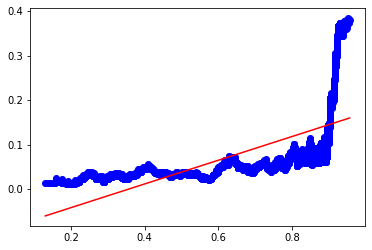

m value: 0.26591055764117677
q value: -0.09440246199910142
r value: 0.5418729211614951
r squared: 0.2936262626880919


In [ ]:
def sorting_smoothing_method(y_true, y_probs, n_smooth, use_actual = True):
  sort_idx = np.argsort(y_probs[:, 0])
  n_total = y_true.shape[0]
  p_vec = np.zeros(n_total)
  for i in range(0, n_total):
    acc = y_true[sort_idx[i]]
    n_acc = 0
    for n in range(0, n_smooth):
      if i + n < n_total:
        acc += y_true[sort_idx[i + n]]
        n_acc += 1
      if i - n >= 0:
        acc += y_true[sort_idx[i - n]]
        n_acc += 1
    if use_actual == True:
      p_vec[i] = acc / ((2 * n_acc) + 1)
    else:
      p_vec[i] = acc / ((2 * n_smooth) + 1)
  return p_vec

p_vec = sorting_smoothing_method(data_y, Y_pred_probabilities_np, 100, use_actual = True)
ord_probs = np.sort(Y_pred_probabilities_np[:, 0])[::-1]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ord_probs, p_vec)

plt.plot(ord_probs, p_vec, 'o', color='blue')
plt.plot(ord_probs, slope*ord_probs + intercept, color = "red")
plt.show()

print("m value: " + str(slope))
print("q value: " + str(intercept))
print("r value: " + str(r_value))
print("r squared: " + str(np.power(r_value, 2)))

In [ ]:
spark.stop()